In [1]:
import numpy as np

import argopandas as argo
import bgcArgoDMQC as bgc
from deconv import deconv_master as deconv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

In [2]:
# grab floats with MTIME and DOXY measurements, load one
ix = argo.bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')[:1]
# ix = argo.float(6900890).bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')
data = ix.levels[['MTIME', 'PRES', 'TEMP_DOXY', 'DOXY', 'DOXY_QC']]
data = data[data.MTIME.notna()]
data = data[data.DOXY.notna()]

# reverse all the arrays so they are forward in time rather than pressure, convert time to seconds
time  = (data.MTIME[::-1].values - data.MTIME.min())*60*60*24
obs   = data.DOXY[::-1].values
pres  = data.PRES[::-1].values
temp  = data.TEMP_DOXY[::-1].values
data

Reading 1 file                                                        


MTIME  \
file                                       N_PROF N_LEVELS             
coriolis/3901668/profiles/BD3901668_001.nc 2      0        -0.002280   
                                                  1        -0.002546   
                                                  2        -0.002813   
                                                  3        -0.002963   
                                                  4        -0.004225   
...                                                              ...   
                                                  391      -0.262141   
                                                  392      -0.262778   
                                                  393      -0.263426   
                                                  394      -0.264063   
                                                  395      -0.265093   

                                                                   PRES  \
file                                       N_PROF N_LEVELS                
coriolis/3901668/profiles/BD3901668_001.nc 2      0            3.612000   
                                                  1            5.134000   
                                                  2            6.706000   
                                                  3            7.596000   
                                                  4           14.402000   
...                                                                 ...   
                                                  391       1964.276001   
                                                  392       1969.858032   
                                                  393       1975.670044   
                                                  394       1981.439941   
                                                  395       1990.845947   

                                                            TEMP_DOXY  \
file                                       N_PROF N_LEVELS              
coriolis/3901668/profiles/BD3901668_001.nc 2      0           4.14108   
                                                  1           4.12116   
                                                  2           4.05817   
                                                  3           3.99724   
                                                  4           3.87270   
...                                                               ...   
                                                  391         3.45930   
                                                  392         3.45735   
                                                  393         3.45480   
                                                  394         3.45197   
                                                  395         3.44774   

                                                                  DOXY DOXY_QC  
file                                       N_PROF N_LEVELS                      
coriolis/3901668/profiles/BD3901668_001.nc 2      0         331.942841    b'3'  
                                                  1         331.445312    b'3'  
                                                  2         331.748718    b'3'  
                                                  3         331.371857    b'3'  
                                                  4         324.849518    b'3'  
...                                                                ...     ...  
                                                  391       262.467072    b'3'  
                                                  392       262.455658    b'3'  
                                                  393       262.538605    b'3'  
                                                  394       262.804749    b'3'  
                                                  395       263.623688    b'3'  

[396 rows x 5 columns]

c:\Users\GordonC\Documents\projects\admt-doxy-correction\notebooks\dolvan-deconv-argo-test\deconv.py:642: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sigma == 'auto':
c:\Users\GordonC\Documents\projects\admt-doxy-correction\notebooks\dolvan-deconv-argo-test\deconv.py:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xhat=n.linalg.lstsq(A,m_v)[0]


Number of model points=10 fit residual norm 2982.38 norm of solution second difference 4036.43 dt=196188480.00 (seconds)
Number of model points=11 fit residual norm 2576.65 norm of solution second difference 4276.70 dt=178353163.64 (seconds)
Number of model points=12 fit residual norm 2194.47 norm of solution second difference 4498.34 dt=163490400.00 (seconds)
Number of model points=13 fit residual norm 1848.40 norm of solution second difference 4575.80 dt=150914215.39 (seconds)
Number of model points=14 fit residual norm 1552.01 norm of solution second difference 4629.69 dt=140134628.57 (seconds)
Number of model points=16 fit residual norm 1170.65 norm of solution second difference 4461.95 dt=122617800.00 (seconds)
Number of model points=18 fit residual norm 997.09 norm of solution second difference 4689.73 dt=108993600.00 (seconds)
Number of model points=20 fit residual norm 886.27 norm of solution second difference 5090.08 dt=98094240.00 (seconds)
Number of model points=22 fit resid

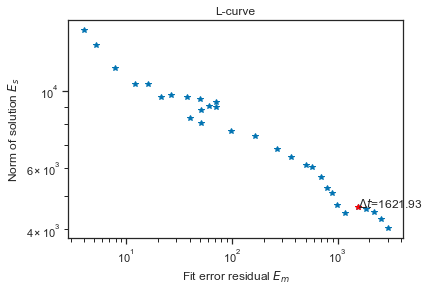

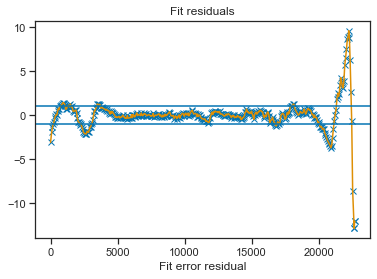

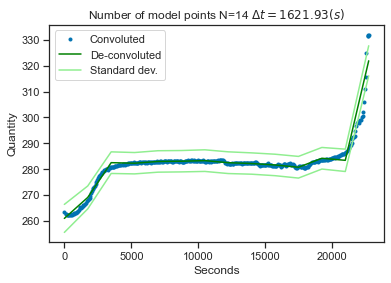

In [3]:
# get tau values from temperature
boundary_layer_thickness = 120
tau = bgc.lookup_tau(boundary_layer_thickness, temp)
k = 1/tau

# correct oxygen with Bittig method
bittig_corr = bgc.correct_response_time(time/60/60/24, obs, temp, boundary_layer_thickness)
# correct with Dolvan method
u_a_est, u_m_est, t_model, u_a_std, resid = deconv(obs, time, k[0], sigma=data.DOXY.std()*np.ones(time.shape))

(200.0, 0.0)

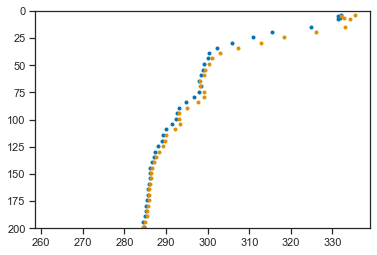

In [5]:
fig, axes = plt.subplots()
axes.plot(obs, pres, '.')
axes.plot(bittig_corr, pres, '.')
axes.set_ylim((200,0))